In [24]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [25]:
import matplotlib
%matplotlib qt5

from pylab import show, ginput, rand, imshow, plot, imread
from matplotlib.figure import Figure
import numpy as np

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import os
from pylab import plot, ginput, show, axis
from scipy.spatial import Delaunay
from skimage.draw import polygon

## Helper Functions

In [5]:
INPUT_PATH = "./imm_face_db/"
OUTPUT_PATH = "output/"

%matplotlib inline
def display_image(image, display=True, addIntDisplay=False):
    if display and addIntDisplay:
        display_image_with_int(image)
        plt.show()
    if display:
        imshow(image)
        plt.show()

In [6]:
def read_image(im_name, depth=True, display=False, saveAs='', input_path=INPUT_PATH):
    if depth:
        im = skio.imread(input_path + im_name)/1.
    else:
        im = skio.imread(input_path + im_name, 2)/1.
    display_image(im, display)
    save_image(im, saveAs)
    return im 

In [7]:
def save_image(image, file_to='', output_path="output/"):
    if file_to:
        imageio.imwrite(output_path + file_to, image)

In [8]:
def load_image(image_name):
    image = imread(image_name)
    return image

In [9]:
def load_image_greyscale(image_name):
    image = io.imread(image_name, as_gray=True)
    return image

In [10]:
def save_plot(plt, saveAs='', display=False, output_path=OUTPUT_PATH):
    if saveAs:
        plt.savefig(output_path + saveAs)
    if display:
        plt.show()

## Part 1: Nose tip detection

Dataloader: Use the dataloader from torch.utils.data.DataLoader. This tutorial shows how to write a custom dataloader. You need to load both the images and the keypoints - you may be able to reuse code from Project 3. Then, you need to convert the image into grayscale and convert image pixel values in uint8 from 0 to 255, to normalized float values in range -0.5 to 0.5 (image.astype(np.float32) / 255 - 0.5). After that, resize the image into smaller size, e.g., 80x60. For loading the facial keypoints including the nose keypoint, we have provided example code. Once you have the dataloader, sample a few images and display them along with the nose keypoints.

In [11]:
# CONSTANTS 

# related to data generation
HEIGHT = 60 #480
WIDTH = 80 #640

MAX_PEOPLE = 40
NUM_IMAGES_PER_PERSON = 6

# related to nueral network 
BATCH_SIZE = 8


class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, all_images, all_landmarks, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.all_images = list(all_images.values())
        self.all_landmarks = list(all_landmarks.values())
        self.image_names = list(all_images.keys())
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = self.all_images[idx%len(self.all_images)]
        #image = image.astype(np.float32) - 0.5
        
        landmarks = self.all_landmarks[idx%len(self.all_landmarks)]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)
    
        return sample

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'landmarks': landmarks}

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
class ToTensorTwo(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image, landmarks):

        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

class ToNoseLandmark(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image,
                'landmarks': np.array([landmarks[-6]])}

In [14]:
def show_landmarks(image, landmarks_pred, landmarks_real):
    """Show image with landmarks"""
    print(image.shape)
    plt.imshow(image, cmap="gray")
    print(landmarks_pred.shape)
    print(landmarks_real.shape)
    plt.scatter(landmarks_pred[:, 0], landmarks_pred[:, 1], s=10, marker='.', c='r')
    plt.scatter(landmarks_real[:, 0], landmarks_real[:, 1], s=10, marker='.', c='g')
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_landmarks_display(image, landmarks, w=WIDTH, h=HEIGHT, display=True, saveAs=''):
    """Show image with landmarks"""
    if display:
        imshow(image, cmap='gray')
        x =[]
        y =[]
        for point in landmarks:
            x.append(point[0]*w)
            y.append(point[1]*h)
        plt.scatter(x, y, s=30, marker='.', c='r')
        save_plot(plt, saveAs=saveAs)
        plt.pause(0.001)  # pause a bit so that plots are updated

In [15]:
def load_images_landmarks(w=WIDTH,h=HEIGHT):
    all_images = {}
    all_landmarks = {}

    for file_name in np.sort(os.listdir(INPUT_PATH)):
        name = file_name.split('.')[0]
        
        # load all facial keypoints/landmarks
        if(file_name.endswith(".asf")):
            # load all facial keypoints/landmarks
            file = open(INPUT_PATH + file_name)
            points = file.readlines()[16:74]
            landmark = []

            for point in points:
                x,y = point.split('\t')[2:4]
                landmark.append([float(x)*60, float(y)*80]) 
            all_landmarks[name] = (landmark)
        if(file_name.endswith(".jpg")):
            grey_image = load_image_greyscale(INPUT_PATH + file_name)
            grey_image = grey_image.astype(np.float32) - 0.5
            grey_image = transform.resize(grey_image, (w,h))
            all_images[name] = grey_image
    return all_images, all_landmarks

def load_display_images_landmarks():
    all_images = {}
    all_landmarks = {}

    for filename in np.sort(os.listdir(INPUT_PATH)):
        name = filename.split('.')[0]
        print(filename)
        if(filename.endswith(".pdf")):
            break
        # load all facial keypoints/landmarks
        elif(filename.endswith(".asf")):
            print("added asf")
            # load all facial keypoints/landmarks
            content = open(INPUT_PATH + filename, 'r')
            lines = content.readlines()
            num_points = int(lines[9])
            points = []

            for i in range(num_points):
                data_line = lines[i + 16].split(" \t")
                points.append([float(data_line[2]), float(data_line[3])])
            
            all_landmarks[name] = points
        elif(filename.endswith(".jpg")):
            print("added jpg")
            original = load_image_greyscale(INPUT_PATH + file_name)
            image = original.astype(np.float32) - 0.5
            image = image.resize((80,60))
            #show_landmarks_display(image, all_landmarks[name], w=80, h=60, display=True)
            all_images[name] = image
            
    return all_images, all_landmarks


In [16]:
def show_landmarks_dataset(dataset, max_display=-1, w=WIDTH, h=HEIGHT):
    fig = plt.figure()

    for i in range(len(dataset)):
        sample = dataset[i]
        
        ax = plt.subplot(1, 4, i + 1)

        print(i, sample['image'].shape, sample['landmarks'].shape)

        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        show_landmarks_display(sample['image'], sample['landmarks'])

        if i == max_display - 1:
            plt.show()
            break

In [17]:
def show_landmarks_one(image, landmarks_pred, color='r',saveAs=''):
    """Show image with landmarks"""
    plt.imshow(image, cmap="gray")
    
    plt.scatter(landmarks_pred[:, 0], landmarks_pred[:, 1], s=10, marker='.', c=color)
    save_plot(plt, saveAs=saveAs)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_landmarks_one_scale_up(image, landmarks_pred, w=80,h=60,color='r',saveAs=''):
    """Show image with landmarks"""
    plt.imshow(image, cmap="gray")
    plt.scatter(landmarks_pred[:, 0]*w, landmarks_pred[:, 1]*h, s=10, marker='.', c=color)
    save_plot(plt, saveAs=saveAs)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
all_images, all_landmarks = load_images_landmarks()

data_transform = transforms.Compose([Rescale((80,60)), ToNoseLandmark(), ToTensor()])

face_dataset = FaceLandmarksDataset(all_images=all_images, all_landmarks = all_landmarks, transform = data_transform)


0 torch.Size([80, 60]) torch.Size([1, 2])


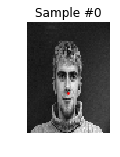

1 torch.Size([80, 60]) torch.Size([1, 2])


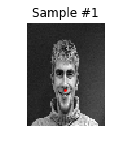

2 torch.Size([80, 60]) torch.Size([1, 2])


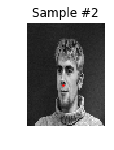

3 torch.Size([80, 60]) torch.Size([1, 2])


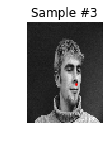

In [19]:
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    landmarks = np.array(sample['landmarks']).astype('float32') 
    show_landmarks_one(sample['image'],landmarks)

    if i == 3:
        plt.show()
        break

# CNN

CNN: Once you have the dataloader, write a convolutional neural network using torch.nn.Module. This tutorial gives an example of how to write a neural network in PyTorch. If you are not familiar with PyTorch or CNN architectures, please refer to this tutorial. Our CNNs will use a convolutional layer (torch.nn.Conv2d), max pooling layer (torch.nn.MaxPool2d) and Rectilinear Unit as non-linearity (torch.nn.ReLU). The architecture of your neural network should be 3-4 convolutional layers, 12-32 channels each. The kernel/filter size for each convolutional layer should be 7x7, 5x5 or 3x3. Each convolutional layer will be followed by a ReLU followed by a maxpool. Finally, this should be followed by 2 fully connected layers. Apply ReLU after the first fully connected layer (but not after the last fully connected layer). You should play around with different design choices to improve your result.


In [33]:
%matplotlib inline
def visualize_output(test_images, test_outputs,gt_pts=None, total_pics = 40, batch_size=8, reshape_size=2,saveAs=''):
    
    test_dataset = []
    for i in range(8):
        test_dataset.append(face_dataset[40-i])
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,**kwargs)
    actual_pts = []
    for batch_i,data in enumerate(test_loader):
        with torch.no_grad():
            images = data['image']
            key_pts = data['landmarks'][-6]
            key_pts = key_pts.view(key_pts.size(0), -1)
        actual_pts += key_pts
    
    for i in range(batch_size):
        plt.figure(figsize=(40, 30))
        ax = plt.subplot(1, batch_size, i+1)

        actual_image = test_images[i].data   # get the image from it's Variable wrapper
        
        image = actual_image.numpy()   # convert to numpy array from a Tensor
    
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = np.array(predicted_key_pts).astype('float32') 
        #predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts.reshape(1,reshape_size)
        actual_pts = gt_pts[i].data
        
        actual_pts = np.array(actual_pts).astype('float32')
        
#         print(predicted_key_pts.shape)
#         print(actual_pts.shape)
        
        show_landmarks_one(actual_image,predicted_key_pts, 'r', saveAs=saveAs)
        show_landmarks_one(actual_image,actual_pts, 'g', saveAs=saveAs)

    plt.show()


In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils

class Net_(nn.Module):

    def __init__(self):
        super(Net_, self).__init__()

        self.conv1 = nn.Conv2d(1, 12, 3, padding=2)
        self.conv2 = nn.Conv2d(12, 18, 5, padding=1)
        self.conv3 = nn.Conv2d(18, 28, 5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fcl1 = nn.Linear(980, 84)
        self.fcl2 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fcl1(x)
        x = F.relu(x)

        x = self.fcl2(x)

        return x

## Loss Function and Optimizer
Now that you have the predictor (CNN) and the dataloader, you need to define the loss function and the optimizer before you can start training your CNN. You will use mean squared error loss (torch.nn.MSELoss) as the prediction loss. Train your neural network using Adam (torch.optim.Adam) with a learning rate of 1e-3 . Run the training loop for 10 to 25 epoches (one epoch means going through all training images). Try different different learning rates.

In [34]:
# CONSTANTS 
LEARNING_RATE = 0.001
N_EPOCHS = 25
TRANSFORMATIONS = [Rescale((80,60)), ToTensor()]
BATCH_SIZE = 8

nose_net = Net_()
data_nose_transform = [Rescale((80,60)), ToNoseLandmark(), ToTensor()]

all_images, all_landmarks = load_images_landmarks()
indices = list(all_images.keys())
training_indices = indices[:32*6]
testing_indices = indices[32*6:]

get_info = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y)])

train_face_images = get_info(all_images, training_indices)
train_face_corr_pts = get_info(all_landmarks, training_indices)

test_face_images = get_info(all_images, testing_indices)
test_face_corr_pts = get_info(all_landmarks, testing_indices)


train_dataset = FaceLandmarksDataset(all_images=train_face_images, 
                            all_landmarks=train_face_corr_pts,
                            transform=transforms.Compose(data_nose_transform))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=0)


test_dataset = FaceLandmarksDataset(all_images=test_face_images, 
                            all_landmarks=test_face_corr_pts,
                            transform=transforms.Compose(data_nose_transform))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=0)


In [35]:
def train_net(train_dataset, test_dataset, train_dataloader, test_dataloader, net, transformations=TRANSFORMATIONS, w=WIDTH, h=HEIGHT, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_epochs=25, reshape_size=2, saveAs=''):
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0)
    criterion = nn.MSELoss().cuda()
        
    net.train()
    
    training_losses = []
    validation_losses = []
    counter = 0
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for batch_i, sample in enumerate(train_dataloader):
            images = sample['image']
            landmarks = sample['landmarks']

            landmarks = landmarks.view(landmarks.size(0), -1)

            images, landmarks = Variable(images), Variable(landmarks)

            images = images.type(torch.FloatTensor)
            landmarks = landmarks.type(torch.FloatTensor)
            
            output_pts = net(images)
            
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, landmarks)
            running_loss += loss.item()
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            print("training: ")
            print(batch_i)
            if (batch_i+1)%10 == 0: 
                print('Epoch [{}/{}],Iter [{}/{}] Loss: {:.4f}, average_loss: {:.4f}'.format(
                        epoch+1, n_epochs, batch_i+1, len(train_dataloader), loss.item(), running_loss/(batch_i+1)))

        running_loss/=len(train_dataset)/batch_size
        training_losses.append(running_loss)
        
        print('training loss is {}'.format(running_loss))
            
        val_loss=0.0
        net.eval()

        for batch_i,data in enumerate(test_dataloader):
            print("validating: ")
            print(batch_i)
            image_batch, landmarks_batch = sample['image'], sample['landmarks']

            images = sample['image']
            landmarks = sample['landmarks']

            landmarks = landmarks.view(landmarks.size(0), -1)

            images, landmarks = Variable(images), Variable(landmarks)

            images = images.type(torch.FloatTensor)
            landmarks = landmarks.type(torch.FloatTensor)

            output_pts = net(images)

            output_pts_batch = output_pts.detach().numpy()

            if epoch == n_epochs - 1 and batch_i == len(test_dataloader) - 1:
                saveAs=saveAs+str(counter)
                visualize_output(image_batch, output_pts, landmarks_batch, reshape_size= reshape_size,saveAs=saveAs)
                counter = counter + 1

            loss = criterion(output_pts, landmarks)
            val_loss+=loss.item()

        val_loss/=len(test_dataset)/batch_size
        validation_losses.append(val_loss)

        print('validation loss is {} \n'.format(val_loss))
        
    return training_losses, validation_losses

In [36]:
training_losses, validation_losses = train_net(train_dataset, test_dataset, train_dataloader, test_dataloader, nose_net, transformations=data_nose_transform, saveAs="nose")


training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [1/25],Iter [10/24] Loss: 1257.3281, average_loss: 1589.1273
training: 
10
training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [1/25],Iter [20/24] Loss: 329.0690, average_loss: 996.1014
training: 
20
training: 
21
training: 
22
training: 
23
training loss is 843.0432016054789
validating: 
0
validating: 
1
validating: 
2
validating: 
3
validating: 
4
validating: 
5
validation loss is 59.322288513183594 

training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [2/25],Iter [10/24] Loss: 35.2811, average_loss: 80.2981
training: 
10
training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [2/25],Iter [20/24] Loss: 14.0804, ave

training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [14/25],Iter [20/24] Loss: 18.2316, average_loss: 16.6200
training: 
20
training: 
21
training: 
22
training: 
23
training loss is 16.104305823644
validating: 
0
validating: 
1
validating: 
2
validating: 
3
validating: 
4
validating: 
5
validation loss is 16.734949111938477 

training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [15/25],Iter [10/24] Loss: 13.5547, average_loss: 17.3158
training: 
10
training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [15/25],Iter [20/24] Loss: 24.1232, average_loss: 16.3146
training: 
20
training: 
21
training: 
22
training: 
23
training loss is 16.16709193587303
validating: 
0
validating: 
1
validating: 
2
validating: 
3
validating: 
4
validating: 
5
validation l

NameError: name 'kwargs' is not defined

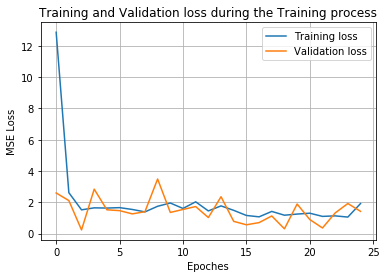

In [1470]:
plt.plot(range(N_EPOCHS), training_losses, label = "Training loss")
plt.plot(range(N_EPOCHS), validation_losses, label = "Validation loss")
plt.xlabel('Epoches')
plt.ylabel('MSE Loss')
plt.title('Training and Validation loss during the Training process')
plt.legend()
plt.grid()
save_plot(plt, saveAs="nose_loss_graph.png")
plt.show()


In [38]:
print(nose_net)

Net_(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 18, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(18, 28, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcl1): Linear(in_features=980, out_features=84, bias=True)
  (fcl2): Linear(in_features=84, out_features=2, bias=True)
)


## Part 2
We are not satisfied with just detecting the nose tip position - in this section we want to move forward and detect all 58 facial keypoints/landmarks. You need to use the same dataset as Part 1 but now try to load all 58 keypoints and predict them.



## Dataloader
The code in this section should be similar to part 1, but this time, try a larger input image size like 160x120 or 240x180. Since it is a small dataset, we will also need data augmentation to prevent the trained model from overfitting. Check this tutorial to learn more about data augmentation in PyTorch. There are many ways to perform data augmentation, including randomly changing the brightness and saturation of the resized face (torchvision.transforms.ColorJitter), randomly rotating the face for like -15 to 15 degrees, and randomly shifting the face for like -10 to 10 pixels. Note that if you rotate or shift the image, you will also need to update the keypoints so that they reflect the change. Once you have the dataloader, sample a few images and display them along with the ground-truth keypoints.

In [41]:
import visdom
import numpy as np
kwargs = {'num_workers': 3} if torch.cuda.is_available() else {}

# CONSTANTS 
AUGMENTED_NUM = 3 
AUG_HEIGHT = 120 #480
AUG_WIDTH = 160 #640

In [48]:
from PIL import Image 
from skimage.transform import rotate
import random

class RandomRotation(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        rv_angle = int((random.random()*30)-15)
        radians = -rv_angle*np.pi/180
        image = rotate(image, rv_angle)
        x_old = landmarks[:, 0]
        y_old = landmarks[:, 1]
        center_x = 0.5
        center_y = 0.5
        
        x_new = center_x + (x_old - center_x) * np.cos(radians) - (y_old - center_y) * np.sin(radians)
        y_new = center_y + (x_old - center_x) * np.sin(radians) + (y_old - center_y) * np.cos(radians)
        return {'image': image,
                'landmarks': np.array(list(zip(x_new, y_new)))}

## CNN
With larger input images, you need to have more convolution layers in the neural network. Write a CNN with 5-6 convolution layers for this task. Each convolution layer should be followed by a ReLU layer, and optionally a maxpool layer. You should play around with different design choices to improve your result.

In [49]:
class FullFacialNet(nn.Module):

    def __init__(self):
        super(FullFacialNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 12, 5, stride=1)
        self.conv2 = nn.Conv2d(12, 24, 3, stride=1)
        self.conv3 = nn.Conv2d(24, 32, 3, stride=1)
        self.conv4 = nn.Conv2d(32, 48, 3, stride=1)
        self.conv5 = nn.Conv2d(48, 64, 1, stride=1)

        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fcl1 = nn.Linear(134784, 24)
        self.fcl2 = nn.Linear(24, 116)

        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        fc1 = nn.Linear(x.shape[1], x.shape[0])
        x = fc1(x)
        x = F.relu(x)
        
        fc2 = nn.Linear(x.shape[0], 116)
        x = fc2(x)

        return x
    

## Loss Function and Optimizer
Now that you have the predictor (CNN) and the dataloader, you need to define the loss function and the optimizer before you can start training your CNN. You will use mean squared error loss (torch.nn.MSELoss) as the prediction loss. Train your neural network using Adam (torch.optim.Adam) with a learning rate of 1e-3 . Run the training loop for 10 to 25 epoches (one epoch means going through all training images). Try different different learning rates.

training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [1/20],Iter [10/30] Loss: 1662.7482, average_loss: 1627.5004
training: 
10
training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [1/20],Iter [20/30] Loss: 1622.1171, average_loss: 1624.0467
training: 
20
training: 
21
training: 
22
training: 
23
training: 
24
training: 
25
training: 
26
training: 
27
training: 
28
training: 
29
Epoch [1/20],Iter [30/30] Loss: 1650.3674, average_loss: 1619.0016
training loss is 4857.004650878906
validating: 
0
validating: 
1
validating: 
2
validating: 
3
validating: 
4
validating: 
5
validation loss is 4953.044982910156 

training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [2/20],Iter [10/30] Loss: 1637.9226, average_loss: 1617.8399
training: 
10
training: 
11


training: 
22
training: 
23
training: 
24
training: 
25
training: 
26
training: 
27
training: 
28
training: 
29
Epoch [11/20],Iter [30/30] Loss: 1593.6992, average_loss: 1619.2661
training loss is 4857.798327636719
validating: 
0
validating: 
1
validating: 
2
validating: 
3
validating: 
4
validating: 
5
validation loss is 4781.514343261719 

training: 
0
training: 
1
training: 
2
training: 
3
training: 
4
training: 
5
training: 
6
training: 
7
training: 
8
training: 
9
Epoch [12/20],Iter [10/30] Loss: 1640.5001, average_loss: 1616.1020
training: 
10
training: 
11
training: 
12
training: 
13
training: 
14
training: 
15
training: 
16
training: 
17
training: 
18
training: 
19
Epoch [12/20],Iter [20/30] Loss: 1590.1034, average_loss: 1609.0567
training: 
20
training: 
21
training: 
22
training: 
23
training: 
24
training: 
25
training: 
26
training: 
27
training: 
28
training: 
29
Epoch [12/20],Iter [30/30] Loss: 1638.3569, average_loss: 1619.1909
training loss is 4857.572692871094
validat

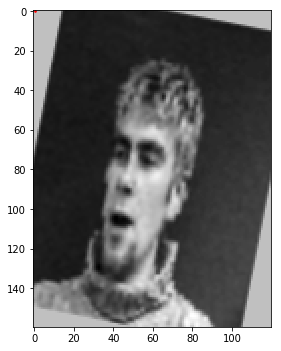

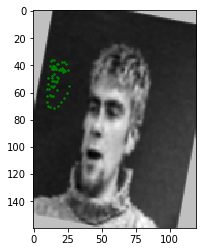

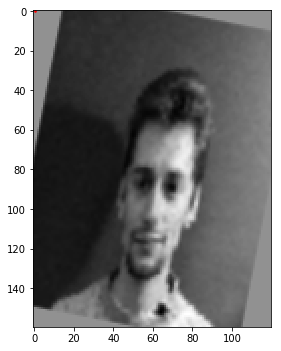

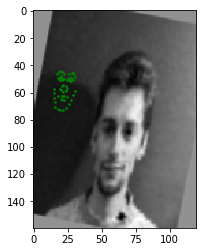

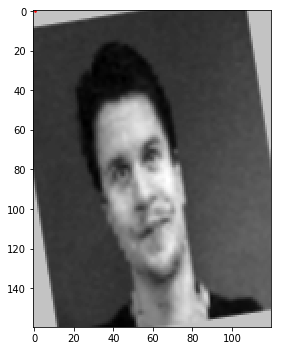

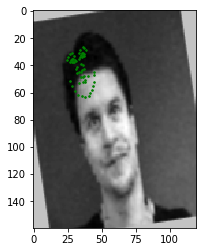

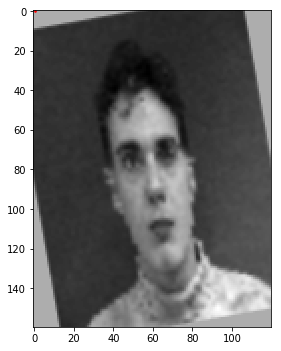

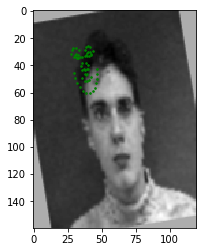

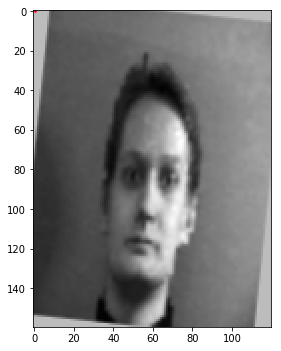

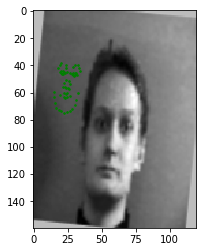

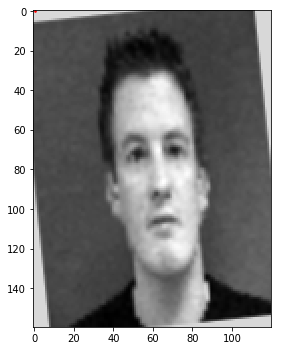

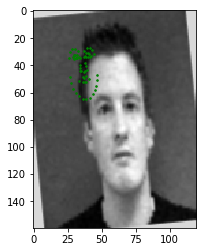

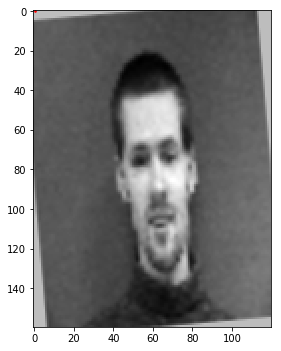

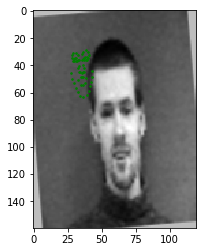

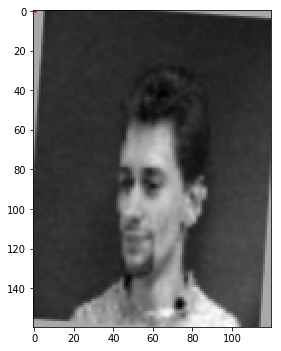

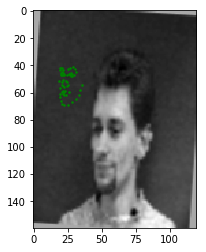

validation loss is 4898.7327880859375 



In [56]:
full_facial_net = FullFacialNet()
full_face_transformations = [Rescale((AUG_WIDTH,AUG_HEIGHT)), RandomRotation(), ToTensor()]

full_face_images, full_face_landmarks = load_images_landmarks()
indices = list(full_face_images.keys())

full_training_indices = indices[:32*6]
full_testing_indices = indices[32*6:]

get_info = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y)])

train_full_face_images = get_info(full_face_images, full_training_indices)
train_full_face_pts = get_info(full_face_landmarks, full_training_indices)

test_full_face_images = get_info(full_face_images, full_testing_indices)
test_full_face_corr_pts = get_info(full_face_landmarks, full_testing_indices)


full_train_dataset = FaceLandmarksDataset(all_images=full_face_images, 
                            all_landmarks=full_face_landmarks,
                            transform=transforms.Compose(full_face_transformations))
full_train_dataloader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=0)


full_test_dataset = FaceLandmarksDataset(all_images=test_full_face_images, 
                            all_landmarks=test_full_face_corr_pts,
                            transform=transforms.Compose(full_face_transformations))
full_test_dataloader = DataLoader(full_test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=0)


full_face_training_losses, full_face_validation_losses = train_net(full_train_dataset, full_test_dataset, full_train_dataloader, full_test_dataloader, full_facial_net, transformations=full_face_transformations, w=AUG_WIDTH, h=AUG_HEIGHT, batch_size=24, learning_rate=0.001, n_epochs=20, reshape_size=116, saveAs='face')


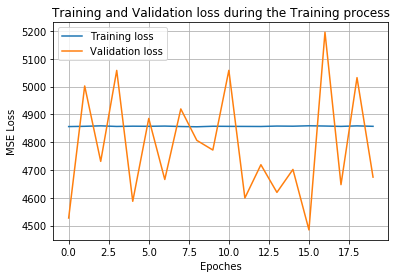

In [54]:

plt.plot(range(20), full_face_training_losses, label = "Training loss")
plt.plot(range(20), full_face_validation_losses, label = "Validation loss")
plt.xlabel('Epoches')
plt.ylabel('MSE Loss')
plt.title('Training and Validation loss during the Training process')
plt.legend()
plt.grid()
#save_plot(plt, saveAs="face_loss_graph.png")
plt.show()


#plot_net_loss(training_losses, validation_losses, saveAs='face_loss_graph.png')

In [55]:
print(full_facial_net)

FullFacialNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcl1): Linear(in_features=134784, out_features=24, bias=True)
  (fcl2): Linear(in_features=24, out_features=116, bias=True)
)


In [1652]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

    
class FeatureExtractor(nn.Module):
    def __init__(self, net):
        super(FeatureExtractor, self).__init__()
        self.net = net
        # If you treat GooLeNet as a fixed feature extractor, disable the gradients and save some memory
        for p in self.net.parameters():
            p.requires_grad = False
        # Define which layers you are going to extract
        self.features = nn.Sequential(*list(self.net.children())[:4])

    def forward(self, x):
        return self.features(x)

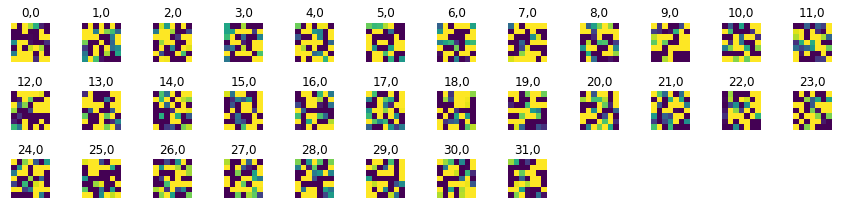

In [1653]:
features = FeatureExtractor(net)

plot_weights(features, 0, single_channel = True)